### import all the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# !pip install catboost --default-timeout=1000

In [3]:
from sklearn.metrics import mean_squared_error , r2_score,mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor , AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression , Lasso , Ridge
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [4]:
from sklearn.preprocessing  import OneHotEncoder ,StandardScaler
from sklearn.compose import ColumnTransformer

In [5]:
path = '../../../All_data_sets/eda_dataset/StudentsPerformance.csv'

df =pd.read_csv(path)

df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### seperate the dependent and independent columns

In [6]:
X = df.drop( columns='math score' )

y = df['math score']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [8]:
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

In [9]:
scaler = StandardScaler()
encoder = OneHotEncoder()

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('StandardScaler',scaler,num_cols),
        ('OneHotEncoder',encoder,cat_cols),
    ]
)

In [11]:
X_transformed = preprocessor.fit_transform(X)

In [12]:
X.shape

(1000, 7)

In [13]:
X_transformed.shape

(1000, 19)

### train test split

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split( X_transformed, y, test_size=0.25, random_state=42 )

In [16]:
def evaluate(y_true , y_pred):
    mae = mean_absolute_error(y_true,y_pred)
    mse = mean_squared_error(y_true,y_pred)
    r2 = r2_score(y_true,y_pred)
    return mae,mse,r2

In [17]:
models = {
    "LinearRegression":LinearRegression(),
    "Lasso": Lasso(),
    "Ridge":Ridge(),
    "SVR":SVR(),
    # "KNeighborsRegressor":KNeighborsRegressor(),
    "DecisionTreeRegressor":DecisionTreeRegressor(),
    "RandomForestRegressor":RandomForestRegressor(),
    "AdaBoostRegressor":AdaBoostRegressor(),
    "CatBoostRegressor" : CatBoostRegressor(verbose=False)
}

In [18]:
r2_score_list = []
model_list = []

In [19]:
# !pip install --upgrade --force-reinstall numpy scikit-learn mkl

In [20]:
for name, model in models.items():
    
    print(f"Training {name}...")
    
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    
    y_test_pred = model.predict(X_test)

    # Evaluate train
    train_mae, train_mse, train_r2 = evaluate(y_train, y_train_pred)
    
    # Evaluate test
    test_mae, test_mse, test_r2 = evaluate(y_test, y_test_pred)
    
    print(f'Training Results:')
    print(f'Mean_absolue_erro:{train_mae}  Mean_squred_error:{train_mse}  R_2_score:{train_r2}')
    print('--------------------------------------------------------------------------------------------')
    
    print(f'Testing Results:')
    print(f'Mean_absolue_erro:{test_mae}  Mean_squred_error:{test_mse}  R_2_score:{test_r2}')
    print('--------------------------------------------------------------------------------------------')

    print("=============================================================================================")
    r2_score_list.append(test_r2)

Training LinearRegression...
Training Results:
Mean_absolue_erro:4.238267465725305  Mean_squred_error:28.06080423568467  R_2_score:0.8742732380399838
--------------------------------------------------------------------------------------------
Testing Results:
Mean_absolue_erro:4.337930600167401  Mean_squred_error:30.05811462672032  R_2_score:0.8778243107659015
--------------------------------------------------------------------------------------------
Training Lasso...
Training Results:
Mean_absolue_erro:5.183725467135435  Mean_squred_error:42.92215298860819  R_2_score:0.8076867909314052
--------------------------------------------------------------------------------------------
Testing Results:
Mean_absolue_erro:5.2217044431408555  Mean_squred_error:44.27742512370272  R_2_score:0.8200278028352899
--------------------------------------------------------------------------------------------
Training Ridge...
Training Results:
Mean_absolue_erro:4.236822709293621  Mean_squred_error:28.0641

In [21]:
results = pd.DataFrame(
    data = {
        'model':models.keys(),
        'r2_score':r2_score_list
    }
).sort_values(by='r2_score' , ascending=False)

results

,model,r2_score
2,Ridge,0.877990
0,LinearRegression,0.877824
7,CatBoostRegressor,0.854830
5,RandomForestRegressor,0.850060
6,AdaBoostRegressor,0.843804
1,Lasso,0.820028
4,DecisionTreeRegressor,0.761519
3,SVR,0.723742


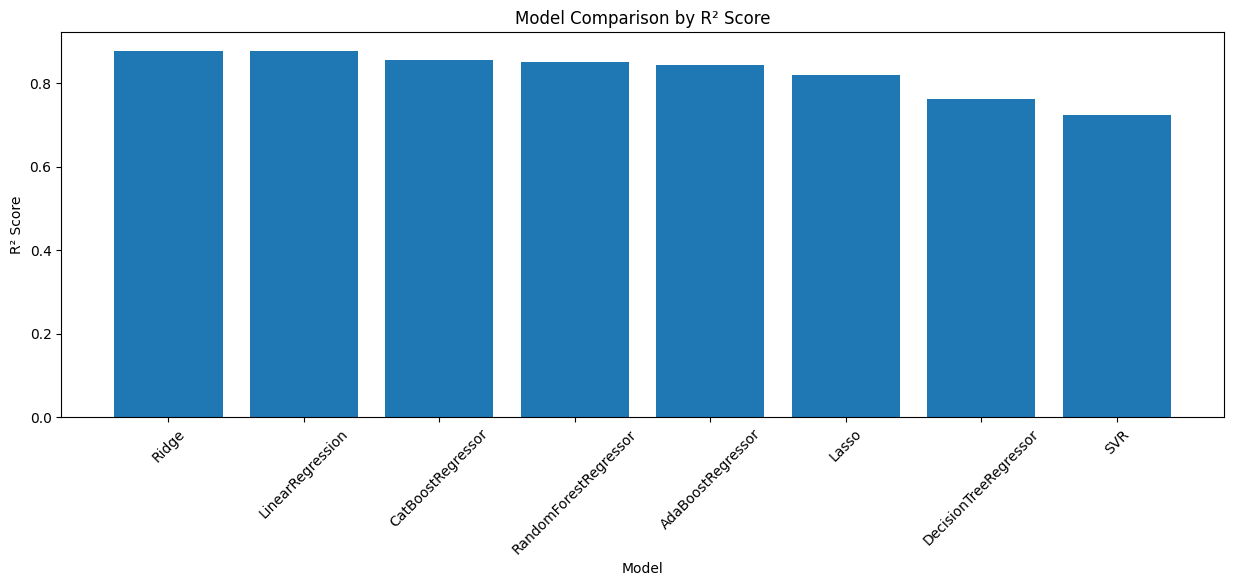

In [22]:
plt.figure(figsize=(15,5))
plt.bar(results['model'], results['r2_score'])
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.xticks(rotation=45)   # rotate labels 45 degrees for readability
plt.title("Model Comparison by R² Score")
plt.show()
